In [303]:
# dataset
import kagglehub
import pandas as pd
import numpy as np
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.base import BaseEstimator, TransformerMixin
# analysis
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import scipy.stats as stats
# data preprocessing
from sklearn.preprocessing import MinMaxScaler
# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
## optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# deep learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K

# Final Assignment

First, download the dataset from Kaggle

In [19]:
import shutil
path = kagglehub.dataset_download("aayushmishra1512/netflix-stock-data")
shutil.move(path+"/NFLX.csv", "./data")

'./data\\NFLX.csv'

After opening the file, we see it's a CSV file with only numerical values, meaning we don't need to change separator, default_na or anything.

In [275]:
nflx_stock = pd.read_csv("data/NFLX.csv")

## EDA and Data preprocessing

### Data Overview

In [21]:
nflx_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [22]:
nflx_stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


In [24]:
nflx_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.7+ KB


In [250]:
print(f"There are {nflx_stock.shape[0] - nflx_stock.drop_duplicates().shape[0]} duplicates.")

There are 0 duplicates.


In [251]:
print(f"There are {nflx_stock.isna().sum().sum()} missing values.")

There are 0 missing values.


#### Let's fix immediate problems with the data.

In [276]:
nflx_stock["Date"] = pd.to_datetime(nflx_stock["Date"])

Close and Adj Close seem similar. Let's check if they have the same values.

In [277]:
nflx_stock["Close"].equals(nflx_stock["Adj Close"])

True

We can see that Close and Adj Close are the same, so we can remove the Adj Close column.

In [278]:
nflx_stock.drop(columns=["Adj Close"], inplace=True)

In date column, we can see there are items only on weekdays. Presumably, because the stock market is closed on weekends. From this information, we can create a new column to indicate which day of the week it is. One might presume more fluctuation and higher volume on monday when market opens (we will ignore holidays for now). 

In [55]:
nflx_stock["Weekday"] = nflx_stock["Date"].dt.weekday

In [30]:
nflx_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Weekday
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,3
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,4
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,1
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,2
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,3


### Column distributions

We plot how the prices changed over time. No need to plot all the columns, as differences throughout the day are marginal compared to the overall trend.

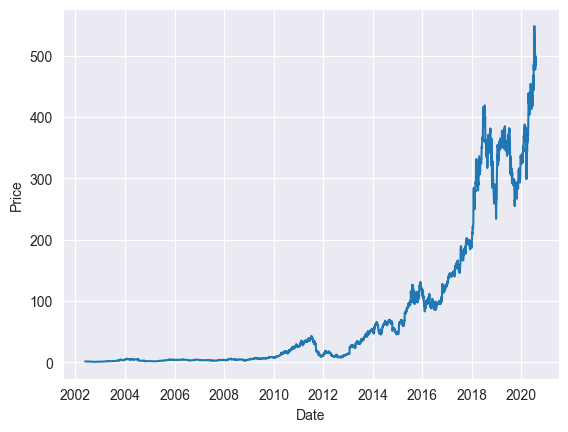

In [45]:
sns.lineplot(data=nflx_stock, x="Date", y="Close")
plt.ylabel("Price")
plt.show()

The price keeps increasing over time, showing the company is growing. Let's see how the volume changes.

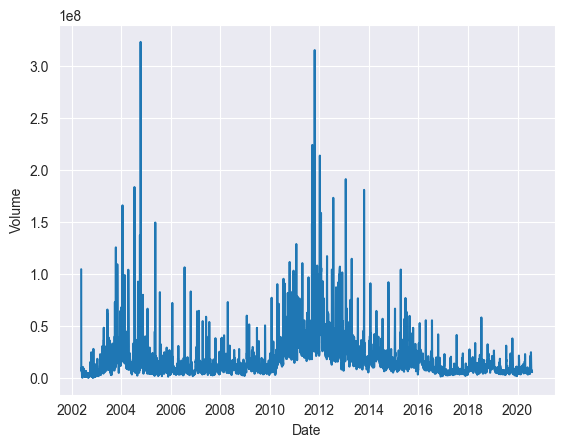

In [50]:
sns.lineplot(data=nflx_stock, x="Date", y="Volume")
plt.show()

The trends in volume aren't as clear compared to the price. We can see two significant spikes in trading volume in late 2004 and in 2012. Overall, later the trading volume is getting lower as time goes.

Let's see how the prices and volumes change depending on the day of the week.

In [59]:
nflx_stock.drop(columns=["Date"]).groupby("Weekday").mean()

,Open,High,Low,Close,Adj Close,Volume
Weekday,,,,,,
0,78.469131,79.860121,77.143506,78.626032,78.626032,1.687406e+07
1,77.886131,79.147035,76.615622,77.938861,77.938861,1.878554e+07
2,77.309623,78.587345,75.987330,77.364613,77.364613,1.775533e+07
3,78.468433,79.703384,77.152493,78.511928,78.511928,1.799244e+07
4,78.068629,79.183218,76.824263,77.970190,77.970190,1.654167e+07


Contrary to our initial assumption, the highest trading volume is in the middle of the workweek, the most on Tuesday. Prices were the highest on Monday though.

Let's visualize how throughout the time, the percentual difference between close and open was the biggest.

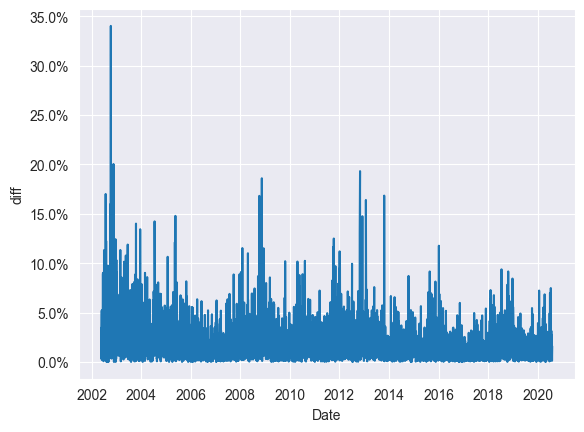

In [28]:
nflx_stock["diff"] = ((nflx_stock["Close"] - nflx_stock["Open"]) / nflx_stock["Open"]).abs()
sns.lineplot(data=nflx_stock, x=nflx_stock["Date"], y=nflx_stock["diff"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

We can see, the prices throughout the day have stabilized a bit since the beginning with fewer and smaller spikes since 2014.

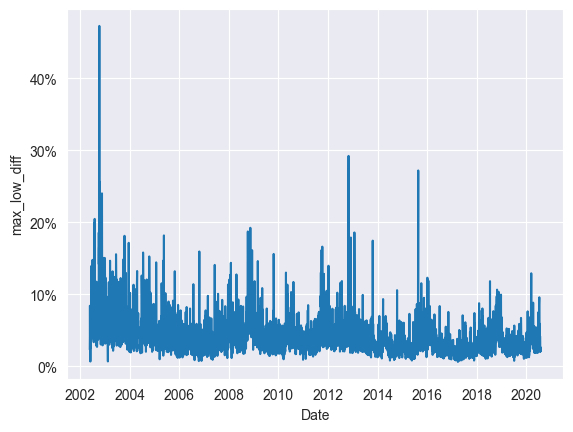

In [30]:
nflx_stock["max_low_diff"] = (nflx_stock["High"] - nflx_stock["Low"]) / nflx_stock["Open"]
sns.lineplot(data=nflx_stock, x=nflx_stock["Date"], y=nflx_stock["max_low_diff"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

We cen see that percentual difference between daily maximum and minimum have been decreasing over time as well.

In [46]:
nflx_stock = nflx_stock.drop(columns=["diff", "max_low_diff"])

### Correlation

In [279]:
nflx_stock.corr()

,Date,Open,High,Low,Close,Volume
Date,1.000000,0.794332,0.794147,0.794708,0.794371,-0.028448
Open,0.794332,1.000000,0.999841,0.999830,0.999654,-0.193770
High,0.794147,0.999841,1.000000,0.999783,0.999840,-0.192107
Low,0.794708,0.999830,0.999783,1.000000,0.999834,-0.195478
Close,0.794371,0.999654,0.999840,0.999834,1.000000,-0.193671
Volume,-0.028448,-0.193770,-0.192107,-0.195478,-0.193671,1.000000


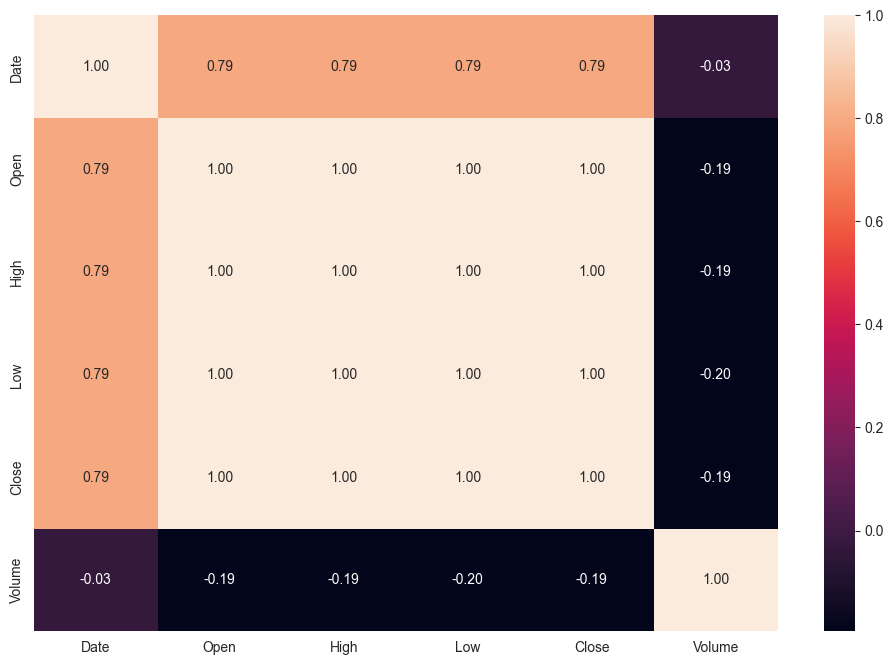

In [280]:
sns.heatmap(nflx_stock.corr(), annot=True, fmt=".2f")
plt.show()

We can see that all the prices are 1.00 correlated with each other, meaning we can likely use only itself to predict itself in the future.  

It also shows that weekday has no correlation with any other column, contradicting our initial assumption, showing the assumptions were coincidental. We can therefore remove the weekday column.

In [56]:
nflx_stock.drop(columns=["Weekday"], inplace=True)

### Stationarity and noise removal

	1. ADF :  2.1260797764442625
	2. P-Value :  0.998815959771424
	3. Num Of Lags :  32


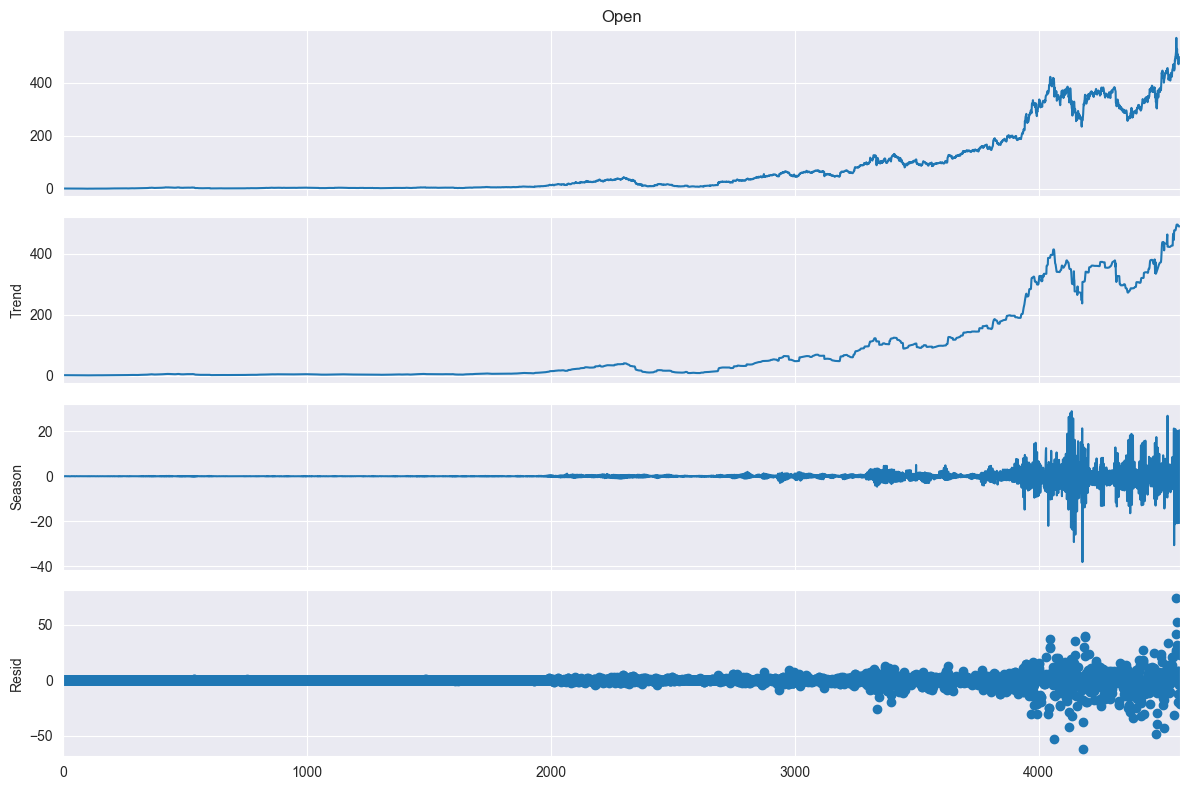

In [281]:
dftest = adfuller(nflx_stock["Open"], autolag = 'AIC')
print("\t1. ADF : ",dftest[0])
print("\t2. P-Value : ", dftest[1])
print("\t3. Num Of Lags : ", dftest[2])
          
result = STL(nflx_stock["Open"], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result.plot()
plt.show()

We remove the noise from all the columns using STL decomposition.

In [282]:
for column in ["Open", "Close", "Low", "High", "Volume"]:
    result = STL(nflx_stock[column], period=6, robust = True).fit()
    nflx_stock[column] = result.trend + result.seasonal

### Scaling
We need to scale the data as volume is in a completely different range compared to all the other columns. For that, we will use MinMax scaling as it best suits our needs.

In [283]:
scaler = MinMaxScaler()
nflx_stock[nflx_stock.columns[1:]] = scaler.fit_transform(nflx_stock[nflx_stock.columns[1:]])

### Transformation
We will find whether we want to transform the data later using Grid Search or Bayes Search.

### Feature Selection
Feature selection will work differently in time series forecasting compared to classification. We will have to use lag/lookback to predict the future, not current state of other columns.  
We will have to adjust the lag and possibly other features and their lag.
As we use lag to depict how data changes over time, we can won't need to use Date column, as the information that price raises over time will already be contained within the lagged columns 

In [11]:
def add_lag(df: pd.DataFrame, column, lag=1):
    for i in range(1, lag+1):
        df[f"{column}_lag_{i}"] = df[column].shift(i)
    return df

We add a function that creates a new dataset based on chosen features and their lags. We don't need to worry about adding weekday in there, as there was no correlation between weekday and any other columns based on the heatmap.

In [114]:
def pick_lagged_features(df: pd.DataFrame, **column_lag_kw):
    df = df.copy()
    selected_columns = []
    for column, lag in column_lag_kw.items():
        if lag == 0:
            continue
        df = add_lag(df, column, lag)
        selected_columns.extend([f"{column}_lag_{i}" for i in range(1, lag + 1)])
    # bfill to deal with rows, where lag was not applicable. Dropna() would cause mismatch in lengths between that and the target column.
    df.bfill(inplace=True)
    return df[selected_columns] 

In [284]:
# example
pick_lagged_features(nflx_stock, Close=2, Volume=1, Low=0)

,Close_lag_1,Close_lag_2,Volume_lag_1
0,0.001463,0.001463,0.028104
1,0.001463,0.001463,0.028104
2,0.001454,0.001463,0.022223
3,0.001414,0.001454,0.046534
4,0.001325,0.001414,0.052610
...,...,...,...
4576,0.950696,0.947405,0.070912
4577,0.942957,0.950696,0.074807
4578,0.929421,0.942957,0.067121
4579,0.938718,0.929421,0.058966


# Finding the best model

Split the data into train and test set. Splitting them randomly makes no sense, as the data is sequential. We split the data at the beginning of 2019 to have roughly 10% of the data as test data.

In [286]:
train = nflx_stock[nflx_stock["Date"] < "2019-01-01"]
test = nflx_stock[nflx_stock["Date"] >= "2019-01-01"]
train.shape[0], test.shape[0]

(4181, 400)

#### We don't define X and y yet, as we are forecasting all values, therefore we will use all columns as y at some point.

## Machine Learning
First, let's try to use the models from sklearn, that are the simplest to use, and see how they perform.

We create a feature selector that we can use in the Bayes Search.


!Note!: We ran the following code in google colab, while the rest was run locally, so we have written the best 

In [130]:
class FeatureLagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, Open_lag=0, Close_lag=0, Low_lag=0, High_lag=0, Volume_lag=0):
        self.Open_lag = Open_lag
        self.Close_lag = Close_lag
        self.Low_lag = Low_lag
        self.High_lag = High_lag
        self.Volume_lag = Volume_lag
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pick_lagged_features(X, **{
            "Open": self.Open_lag,
            "Close": self.Close_lag,
            "Low": self.Low_lag,
            "High": self.High_lag,
            "Volume": self.Volume_lag
        })

In [215]:
def get_best_pipeline(data, predicted_column, estimator, n_iter=100, **estimator_params):
    pipeline = Pipeline([
        ("feature_selector", FeatureLagTransformer()),
        ("model", estimator)
    ])
    # allow greater depth only for the predicted column
    search_space = {
        "feature_selector__Open_lag": Integer(0, 3) if predicted_column != "Open" else Integer(1, 10),
        "feature_selector__Close_lag": Integer(0, 3) if predicted_column != "Close" else Integer(1, 10),
        "feature_selector__Low_lag": Integer(0, 3) if predicted_column != "Low" else Integer(1, 10),
        "feature_selector__High_lag": Integer(0, 3) if predicted_column != "High" else Integer(1, 10),
        # as volume isn't correlated well with the other columns, we have to use a higher lag for predicting itself, but no need for the other columns
        "feature_selector__Volume_lag": Integer(0, 3) if predicted_column != "Volume" else Integer(1, 100),
    }
    # add kwargs for the estimator to the search space
    search_space.update({f"model__{key}": value for key, value in estimator_params.items()})
    optimizer = BayesSearchCV(
        estimator=pipeline, 
        search_spaces=search_space, 
        n_iter=n_iter, 
        cv=5,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        n_jobs=-1,
    )
    optimizer.fit(data, data[predicted_column])
    print(optimizer.best_params_)
    return optimizer.best_estimator_

### Linear Regression
Let's begin with the simplest model as the benchmark, Linear Regression.

In [ ]:
lin_reg_pipelines = {
    "Open": get_best_pipeline(train, "Open", LinearRegression()),
    "Close": get_best_pipeline(train, "Close", LinearRegression()),
    "Low": get_best_pipeline(train, "Low", LinearRegression()),
    "High": get_best_pipeline(train, "High", LinearRegression()),
    "Volume": get_best_pipeline(train, "Volume", LinearRegression())
}

Best parameters for each column:  
"Open":  
[('feature_selector', FeatureLagTransformer(Close_lag=1, High_lag=2, Low_lag=1, Open_lag=1, Volume_lag=1)), ('model', LinearRegression())]  
"Close":  
[('feature_selector', FeatureLagTransformer(Close_lag=1, High_lag=2, Low_lag=2, Open_lag=1, Volume_lag=3)), ('model', LinearRegression())]  
"Low":  
[('feature_selector', FeatureLagTransformer(Close_lag=1, High_lag=2, Low_lag=2, Open_lag=1, Volume_lag=3)), ('model', LinearRegression())]  
"High":  
[('feature_selector', FeatureLagTransformer(Close_lag=2, High_lag=1, Low_lag=1, Open_lag=1, Volume_lag=2)), ('model', LinearRegression())]  
"Volume":  
[('feature_selector', FeatureLagTransformer(Volume_lag=70)), ('model', LinearRegression())]       

In [346]:
lin_reg_results: dict[str, dict] = {}
for key, pipeline in lin_reg_pipelines.items():
    predicted_data = pipeline.predict(test)
    lin_reg_results[key] = {
        "mse": mean_squared_error(test[key], predicted_data),
        "r2": r2_score(test[key], predicted_data),
        "data": predicted_data
    }

for key, item in lin_reg_results.items():
    print(f"{key}: MSE: {item['mse']}, R2: {item['r2']}")

Open: MSE: 0.0018920473604569022, R2: 0.8328676310555411
Close: MSE: 0.00027396875456047983, R2: 0.976786794996164
Low: MSE: 0.0007948821750059049, R2: 0.9351390952423249
High: MSE: 0.0003226880906888626, R2: 0.9720618787110882
Volume: MSE: 0.00019551836006884718, R2: 0.7204147614634957


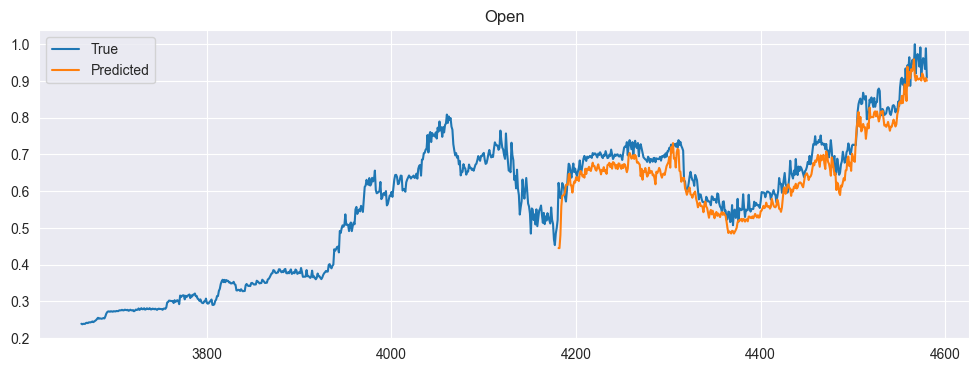

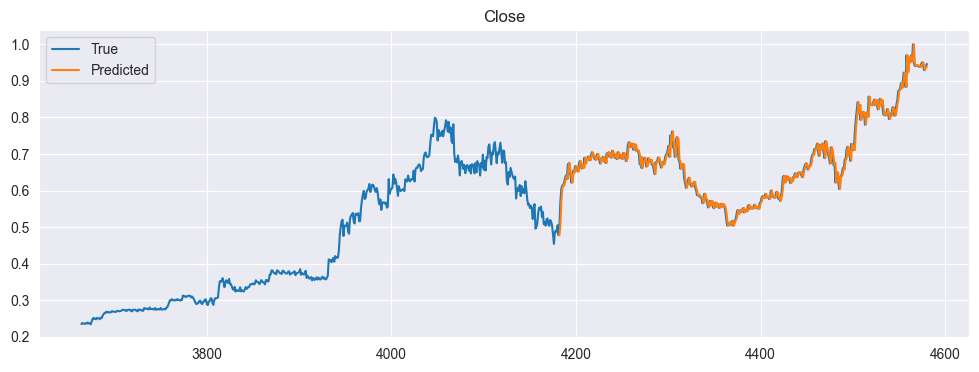

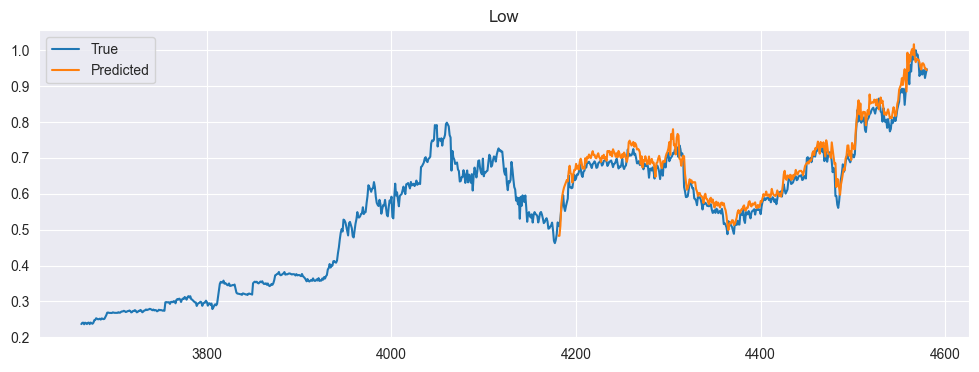

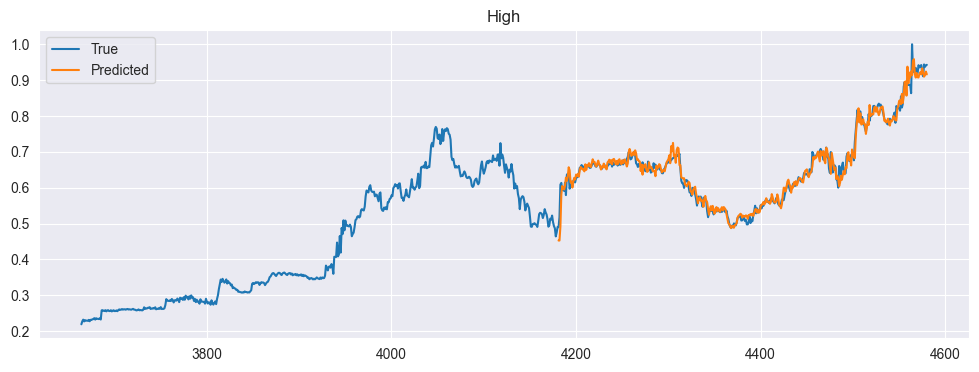

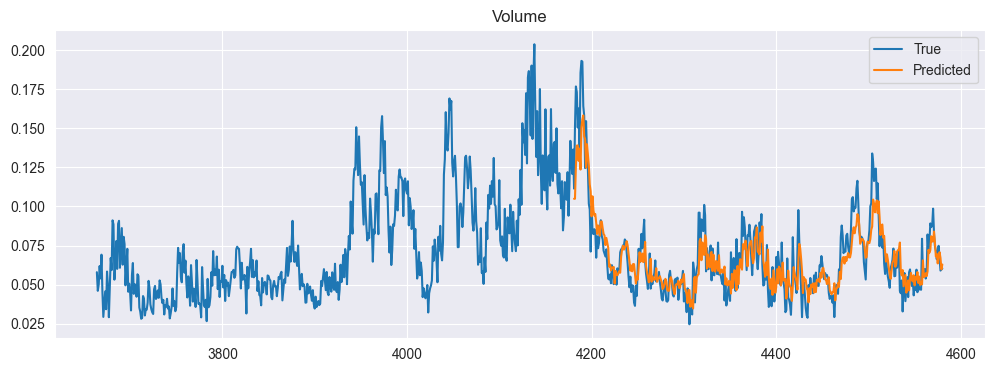

In [363]:
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(lin_reg_results["Open"]["data"])
for col in ["Open", "Close", "Low", "High", "Volume"]:
    y_pred = lin_reg_results[col]["data"]
    y_true = nflx_stock[col].iloc[start_index:]
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True")
    plt.plot(range(pred_padding_length, total_length), y_pred, label="Predicted")
    plt.title(col)
    plt.legend()
    plt.show()

### Random Forest Regressor

In [216]:
rf_hyperparams = {
    "n_estimators": Integer(10, 200),
    "max_depth": Integer(1, 10),
    "criterion": Categorical(["squared_error", "absolute_error", "friedman_mse", "poisson"]),
    "max_features": Categorical(["sqrt", "log2"]),
}
rf_pipelines = {}
for column in ["Open", "Close", "Low", "High", "Volume"]:
    rf_pipelines[column] = get_best_pipeline(train, column, RandomForestRegressor(), **rf_hyperparams)

OrderedDict({'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 0, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 1, 'feature_selector__Volume_lag': 0, 'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__n_estimators': 86})
OrderedDict({'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 0, 'feature_selector__Open_lag': 1, 'feature_selector__Volume_lag': 0, 'model__criterion': 'friedman_mse', 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__n_estimators': 200})
OrderedDict({'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 3, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 3, 'feature_selector__Volume_lag': 0, 'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__n_estimators': 172})
OrderedDict({'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 2, 'feature_selector__

In [217]:
rf_results: dict[str, dict] = {}
for key, pipeline in rf_pipelines.items():
    predicted_data = pipeline.predict(test)
    rf_results[key] = {
        "mse": mean_squared_error(test[key], predicted_data),
        "r2": r2_score(test[key], predicted_data),
        "data": predicted_data
    }
    
for key, item in rf_results.items():
    print(f"{key}: MSE: {item['mse']}, R2: {item['r2']}")

Open: MSE: 0.0016280784841242008, R2: 0.8426467997680598
Close: MSE: 0.0022594836386244273, R2: 0.7962906839793809
Low: MSE: 0.0028270883136234065, R2: 0.7582584649352808
High: MSE: 0.0022280124444500945, R2: 0.7880379336020493
Volume: MSE: 0.00013050536175982674, R2: 0.3311546602188442


Surprisingly, the results for Random Forest Regressor are considerably worse than for Linear Regression.

## Deep Learning

In [318]:
def get_y_from_generator(gen):
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]  # Get the target (y) batch
        if y is None:
            y = batch_y
        else:
            y = np.vstack((y, batch_y))  # Stack the batches vertically
    print(y.shape)  # Confirm shape
    return y


In [375]:
dl_train = train.drop(columns=["Date"])
dl_test = test.drop(columns=["Date"])
look_back = 10
train_data_gen = TimeseriesGenerator(dl_train.values, 
                                     dl_train.values,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=1
                                    )

test_data_gen = TimeseriesGenerator(dl_test.values, 
                                    dl_test.values,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1
                                   )

#### We will use different layers in RNN to see which one performs the best.

### LSTM

In [374]:
x = Input(shape=(look_back, 5)) # 5 columns
h = LSTM(units=15)(x)           # (x) because h is the output layer of x
y = Dense(units=5, activation='sigmoid')(h)
model_lstm = Model(inputs=x, outputs=y)
print(model_lstm.summary())

opt = Adam(learning_rate=0.001)
model_lstm.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 15)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,340 (5.23 KB)

 Trainable params: 1,340 (5.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [376]:
model_lstm.fit(train_data_gen, epochs=20)

Epoch 1/20


C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0178 - mae: 0.0739 - mse: 0.0178
Epoch 2/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 8.6118e-04 - mae: 0.0156 - mse: 8.6118e-04
Epoch 3/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 6.7560e-04 - mae: 0.0133 - mse: 6.7560e-04
Epoch 4/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5.6812e-04 - mae: 0.0117 - mse: 5.6812e-04
Epoch 5/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5.3823e-04 - mae: 0.0111 - mse: 5.3823e-04
Epoch 6/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5.3325e-04 - mae: 0.0107 - mse: 5.3325e-04
Epoch 7/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5.2233e-04 - mae: 0.0102 - mse: 5.2233e-04
Epoch 8/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5.0439e-04 - mae: 0.0101 - mse: 5.0439e-04
Epoch 9/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5.3994e-04 - mae: 0.0100 - mse: 5.3994e-04
Epoch 10/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 4

In [299]:
model_lstm.evaluate(test_data_gen)

C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2361e-04 - mae: 0.0134 - mse: 3.2361e-04


[0.0007541034719906747, 0.0007541034719906747, 0.01892234943807125]

In [309]:
model_lstm.evaluate(train_data_gen)

4171/4171 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.2512e-04 - mae: 0.0087 - mse: 3.2512e-04


[0.00040695781353861094, 0.00040695781353861094, 0.009439476765692234]

In [319]:
testY = get_y_from_generator(test_data_gen)

(390, 5)


In [320]:
predictions = model_lstm.predict(test_data_gen)

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [321]:
predictions.shape

(390, 5)

In [313]:
dl_train.drop(columns=["Predictions"], inplace=True)

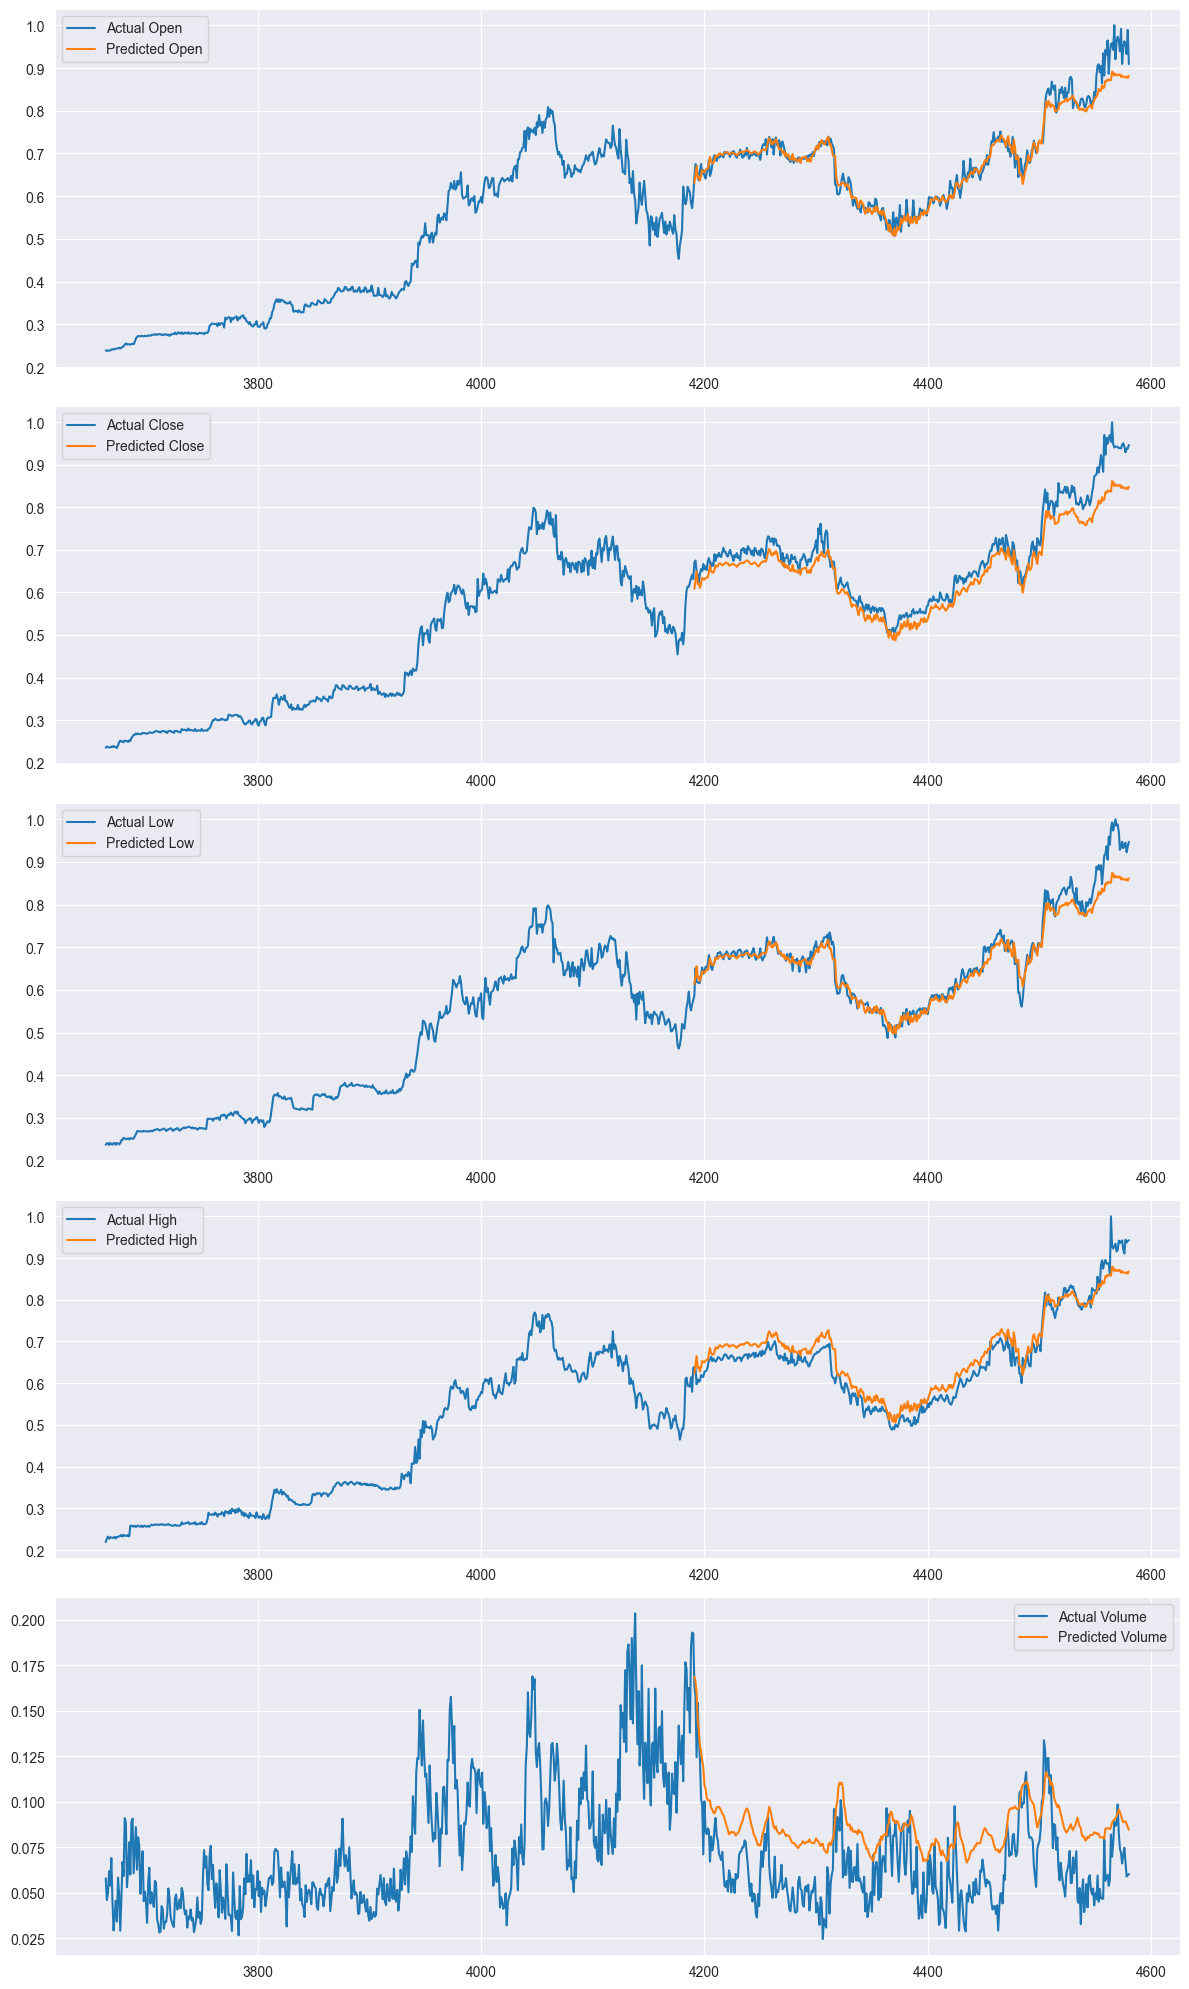

In [355]:
num_features = predictions.shape[1]
plt.figure(figsize=(12, 20))
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(predictions)

feature_names = ["Open", "Close", "Low", "High", "Volume"]
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.plot(nflx_stock[feature_names[i]].iloc[start_index:], label=f"Actual {feature_names[i]}")
    plt.plot(range(pred_padding_length, total_length), predictions[:, i], label=f"Predicted {feature_names[i]}")
    plt.legend()

plt.tight_layout()
plt.show()